In [20]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from vosk import Model
from Signal_Analysis.features.signal import get_HNR
from scipy import signal
from audiostretchy.stretch import stretch_audio


# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

In [21]:
import os
from librosa import load

examples_dir = "example_speech_mp3/svenska"
filenames = os.listdir(examples_dir)
print(filenames)
audios = []
for f in filenames:
    y, Fs = load(os.path.join(examples_dir, f), sr=None)
    audios.append(y)

wavfile.write("wav_examples/svenska_combo.wav", Fs, tools.stitch_frames(audios))

['common_voice_sv-SE_38528961.mp3', 'common_voice_sv-SE_38528962.mp3', 'common_voice_sv-SE_38528964.mp3', 'common_voice_sv-SE_38528967.mp3', 'common_voice_sv-SE_38528968.mp3', 'common_voice_sv-SE_38543999.mp3', 'common_voice_sv-SE_38544000.mp3', 'common_voice_sv-SE_38544001.mp3', 'common_voice_sv-SE_38544002.mp3', 'common_voice_sv-SE_38544004.mp3', 'common_voice_sv-SE_38544013.mp3', 'common_voice_sv-SE_38544014.mp3', 'common_voice_sv-SE_38544015.mp3', 'common_voice_sv-SE_38544016.mp3', 'common_voice_sv-SE_38544017.mp3', 'common_voice_sv-SE_38568655.mp3', 'common_voice_sv-SE_38568656.mp3', 'common_voice_sv-SE_38568657.mp3', 'common_voice_sv-SE_38568658.mp3', 'common_voice_sv-SE_38568659.mp3', 'common_voice_sv-SE_38568660.mp3', 'common_voice_sv-SE_38568661.mp3', 'common_voice_sv-SE_38568662.mp3', 'common_voice_sv-SE_38568663.mp3', 'common_voice_sv-SE_38568664.mp3', 'common_voice_sv-SE_38568670.mp3', 'common_voice_sv-SE_38568671.mp3', 'common_voice_sv-SE_38568672.mp3', 'common_voice_sv-SE

## preprocess

In [22]:
audio_original_path = "wav_examples/svenska_combo.wav"
_ = tools.preprocess(audio_original_path)

preprocessing svenska_combo


## Speech recognition

In [23]:
audio_path = "audio_preproc/svenska_combo_pp.wav"
audio_path = "audio_preproc/180923214834-Y20UOTIE-text-000_pp.wav"

Fs, audio = wavfile.read(audio_path)
model_path = "models/vosk-model-small-sv-rhasspy-0.15/"
if "model" not in locals():
    model = Model(model_path)

i skymningen en mycket het dag i början av juli lämnade en ung man sin kammare som han hörde vid s grand steg ut på gatan och började långsamt och med samma obeslutsam går bort mot jobb men lyckligtvis slapp han möter värdinnan i kappan fanns kammare som låg alldeles in under den höga fem veckor aning byggnadens tak liknande snart ska jag köpa en bostad värdinnan som hyrde ut vind skutan och höll honom med middag som jag mål och städning bodde för sig i en våningen trappar trappa ner och när han skulle ut måste hem passera värdinnan kex ingång där döden nästan alltid sture


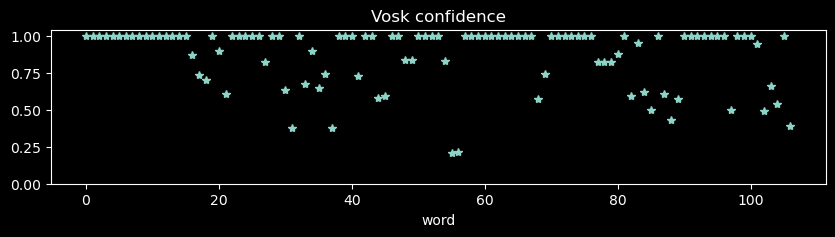

In [24]:
if "words" not in locals():
    words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()

In [25]:
# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)

for i, w in enumerate(words):
    print(i, w["word"], w["vowels"], str(w["conf"] * 100) + "%")

0 i ['i'] 100.0%
1 skymningen ['y', 'i', 'e'] 100.0%
2 en ['e'] 100.0%
3 mycket ['y', 'e'] 100.0%
4 het ['e'] 100.0%
5 dag ['a'] 100.0%
6 i ['i'] 100.0%
7 början ['ö', 'a'] 100.0%
8 av ['a'] 100.0%
9 juli ['u', 'i'] 100.0%
10 lämnade ['ä', 'a', 'e'] 100.0%
11 en ['e'] 100.0%
12 ung ['u'] 100.0%
13 man ['a'] 100.0%
14 sin ['i'] 100.0%
15 kammare ['a', 'a', 'e'] 100.0%
16 som ['o'] 87.0501%
17 han ['a'] 73.67869999999999%
18 hörde ['ö', 'e'] 70.1671%
19 vid ['i'] 100.0%
20 s [] 89.281%
21 grand ['a'] 60.827799999999996%
22 steg ['e'] 100.0%
23 ut ['u'] 100.0%
24 på ['å'] 100.0%
25 gatan ['a', 'a'] 100.0%
26 och ['o'] 100.0%
27 började ['ö', 'a', 'e'] 81.8951%
28 långsamt ['å', 'a'] 100.0%
29 och ['o'] 100.0%
30 med ['e'] 63.4952%
31 samma ['a', 'a'] 37.5446%
32 obeslutsam ['o', 'e', 'u', 'a'] 100.0%
33 går ['å'] 67.3912%
34 bort ['o'] 89.4242%
35 mot ['o'] 64.3671%
36 jobb ['o'] 73.9019%
37 men ['e'] 37.8958%
38 lyckligtvis ['y', 'i', 'i'] 100.0%
39 slapp ['a'] 100.0%
40 han ['a'] 100.0%

## test 1 word

skymningen
['y', 'i', 'e']
['y', 'i', 'e']
frame length    : 882 samples
frame length    : 0.02 seconds
between frames  : 0.02 seconds
number of frames: 42


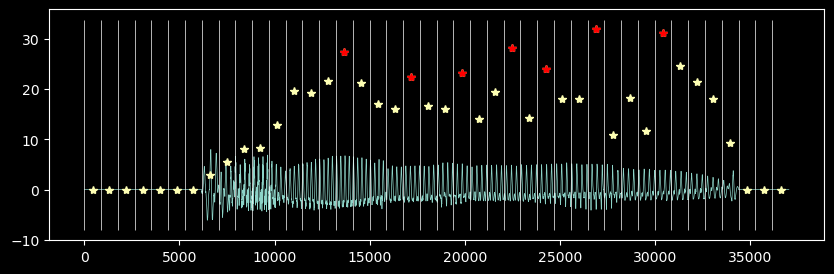

In [26]:
fl = int(0.02 * Fs)
k = 1
word = words[k]["word"]
print(word)
segments, vowels_per_segment, segments_start = tools.segment_by_words(
    words, audio, Fs, tools.VOWELS_SV
)
x = segments[k] / segments[k].max()
vowels = vowels_per_segment[k]

print(vowels)
print(words[k]["vowels"])

frames, f_start = tools.split_frames(x, fl, Fs, overlap=0, vol_thr=0.1, print_info=True)

peak_frames, hnr_frames = tools.HNR_short(frames, Fs, 7, min_dist=False)

plt.figure(figsize=(10, 3))
plt.plot(8 * np.concatenate(frames))
plt.plot(f_start + int(fl / 2), hnr_frames, "*")
plt.plot(f_start[peak_frames] + int(fl / 2), hnr_frames[peak_frames], "*r")
plt.vlines(f_start, *plt.ylim())

plt.show()

wavfile.write(f"output/1word{word}.wav", Fs, tools.stitch_frames(frames))

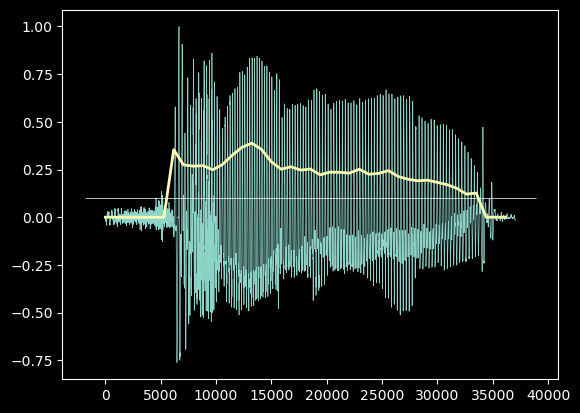

In [27]:
reload(tools)
plt.plot(x)
plt.plot(f_start, [tools.vol(f) for f in frames], linewidth=2)
plt.hlines(0.1, *plt.xlim())
plt.show()

## all words

In [28]:
reload(tools)
add_context = False
grouped_frames = tools.julgran(words, audio, Fs, fl, add_context)

keep i
trash skymningen
keep en
keep mycket
keep het
keep dag
keep i
keep början
keep av
keep juli
keep lämnade
keep en
keep ung
keep man
keep sin
keep kammare
keep vid
keep steg
keep ut
keep på
keep gatan
keep och
keep långsamt
keep och
keep obeslutsam
keep lyckligtvis
trash slapp
keep han
keep värdinnan
keep i
trash kammare
keep som
keep in
keep under
keep den
keep höga
keep byggnadens
keep tak
keep liknande
keep snart
keep ska
keep jag
trash köpa
keep en
trash bostad
keep värdinnan
keep som
keep vind
trash skutan
keep och
keep höll
keep honom
keep med
keep middag
keep städning
keep en
keep ner
keep och
keep när
keep han
keep skulle
keep ut
keep måste
keep passera
keep värdinnan
keep kex
keep alltid


In [29]:
vowels_in_text = {v: 0 for v in tools.VOWELS_SV}
for c in tools.checkVowels(text, tools.VOWELS_SV):
    vowels_in_text[c] += 1


print("found vowels:")
for v in grouped_frames.keys():
    print(
        "    ",
        v,
        len(grouped_frames[v]),
        str(round(100 * len(grouped_frames[v]) / vowels_in_text[v], 3)) + "%",
    )

print("total: vowels in text", sum([vowels_in_text[v] for v in vowels_in_text.keys()]))
for v in vowels_in_text.keys():
    print(vowels_in_text[v])

found vowels:
     e 3 8.108%
     y 3 60.0%
     u 3 30.0%
     i 3 13.043%
     o 3 16.667%
     å 3 37.5%
     a 3 6.122%
     ö 3 33.333%
     ä 3 37.5%
total: vowels in text 167
37
5
10
23
18
8
49
9
8


### Stitch audio out

In [30]:
audio_out = {}
for v in grouped_frames.keys():
    audio_out[v] = tools.stitch_frames(
        grouped_frames[v], fade_pow=0.0, padding=(Fs / 4) * add_context
    )

    if add_context:
        path = f"output/concatenated/concatenated_{v}_wcontext.wav"
    else:
        path = f"output/concatenated/concatenated_{v}.wav"

    wavfile.write(path, Fs, audio_out[v])
    # stretch_audio(path, path, 1)

UFuncTypeError: ufunc 'absolute' did not contain a loop with signature matching types <class 'numpy.dtypes.StrDType'> -> None

## outlier removal

In [ ]:
from sklearn import preprocessing, ensemble
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

grouped_frames_in = {v: [] for v in tools.VOWELS_SV}
inliers = {v: [] for v in tools.VOWELS_SV}

for v in grouped_frames.keys():
    print(v)
    frames = grouped_frames[v]
    mfcc = tools.get_mfcc(frames, Fs, n=20, normalize=True)

    X = np.array(mfcc)

    sc_X = preprocessing.StandardScaler()
    X = sc_X.fit_transform(X)
    print(X.shape)
    clf = ensemble.IsolationForest(random_state=0)
    clf.fit(X)

    inliers[v] = clf.predict(X) > 0

    grouped_frames_in[v] = np.array(frames)[inliers[v]]

    print(f"inliers {np.around(100*sum(inliers[v])/len(X))} %")

i
(18, 20)


inliers 78.0 %
ä
(6, 20)
inliers 83.0 %
ö
(3, 20)
inliers 100.0 %
y
(4, 20)
inliers 100.0 %
u
(7, 20)
inliers 71.0 %
a
(32, 20)
inliers 75.0 %
o
(10, 20)
inliers 60.0 %
å
(3, 20)
inliers 100.0 %
e
(22, 20)
inliers 68.0 %


In [ ]:
audio_out_in = {}
for v in grouped_frames_in.keys():
    audio_out_in[v] = tools.stitch_frames(
        grouped_frames_in[v], fade_pow=0.0, padding=(Fs / 4) * add_context
    )

    path = f"output/concatenated/concatenated_{v}_inliers.wav"
    wavfile.write(path, Fs, audio_out_in[v])

## Look at output

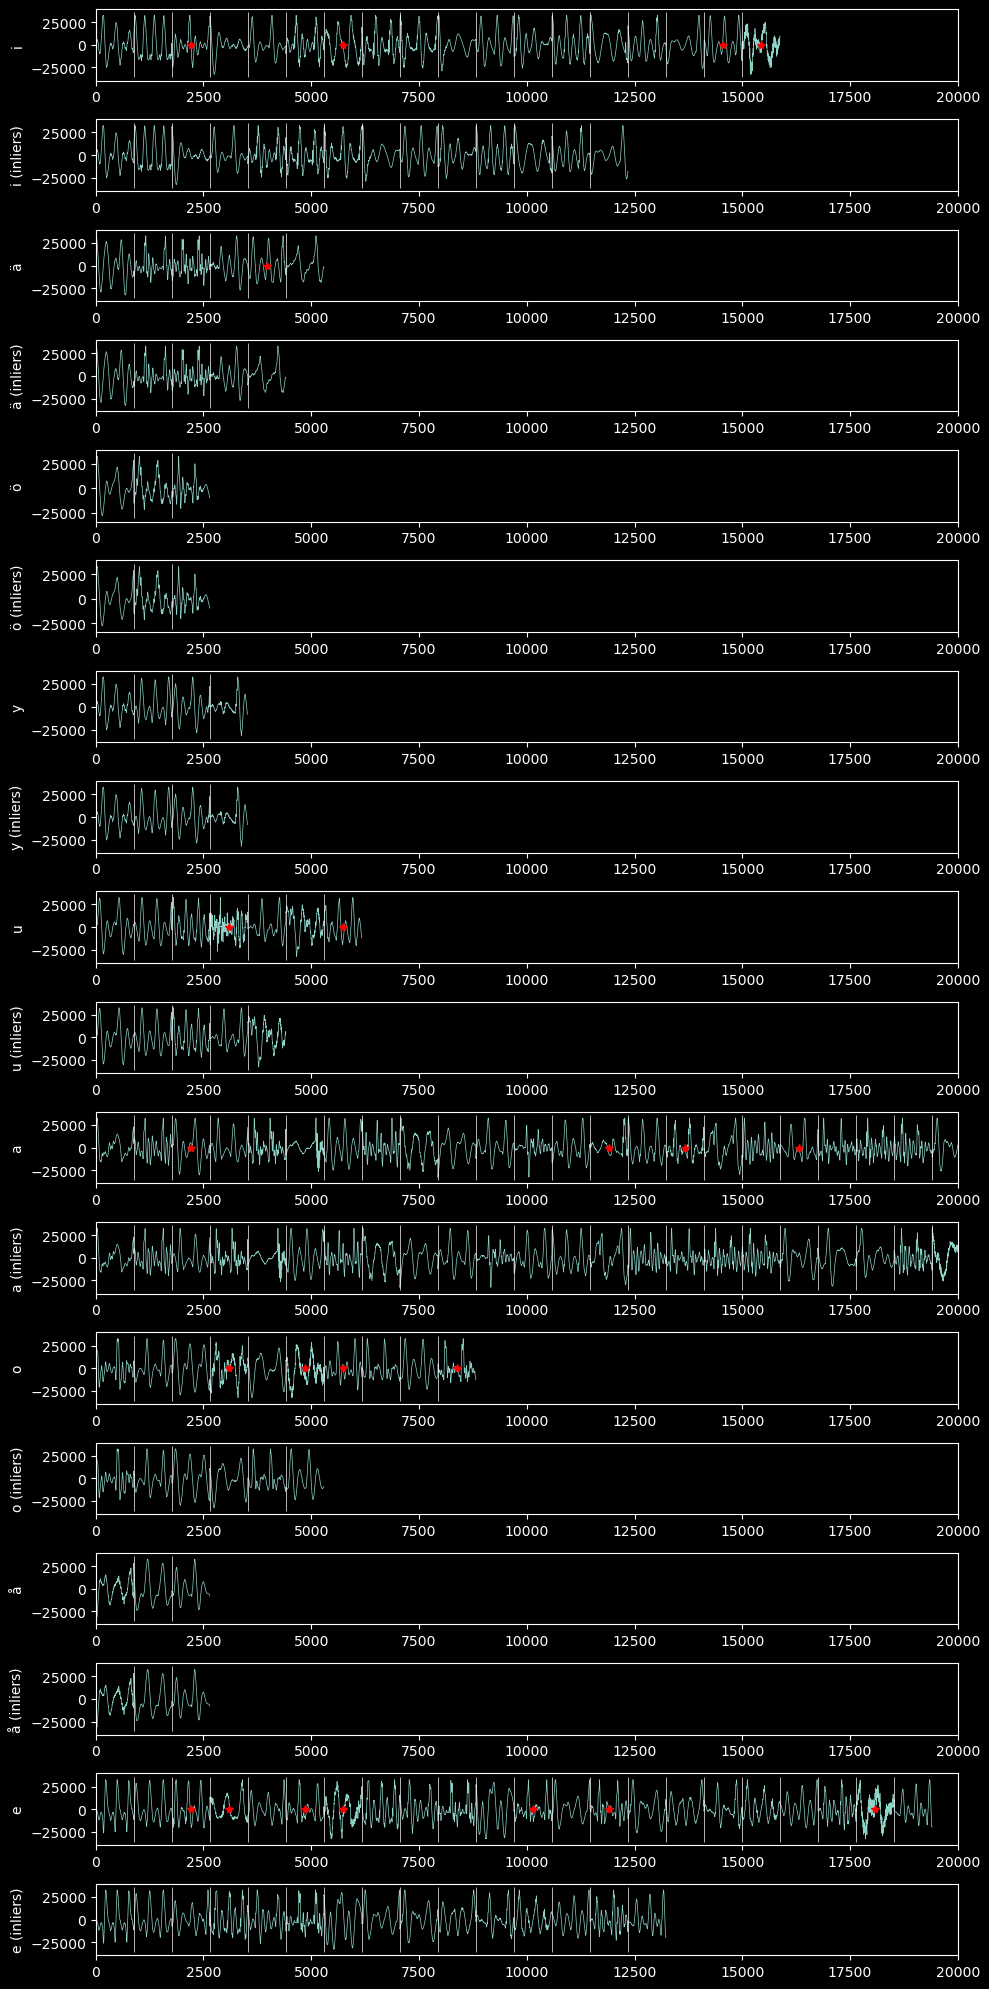

In [ ]:
xmax = 20000
plt.figure(figsize=((10, 20)))
for i, v in enumerate(audio_out.keys()):
    # plot from grouped
    plt.subplot(2 * len(tools.VOWELS_SV), 1, 2 * i + 1)
    plt.plot(audio_out[v])
    tt = np.arange(0, len(audio_out[v]), fl) + fl / 2
    plt.plot(tt[np.logical_not(inliers[v])], 0 * tt[np.logical_not(inliers[v])], "*r")
    plt.xlim(0, xmax)
    plt.vlines(np.arange(0, len(audio_out[v]), fl), *plt.ylim())
    plt.ylabel(v)

    # plot from grouped inliers
    plt.subplot(2 * len(tools.VOWELS_SV), 1, 2 * i + 2)
    plt.plot(audio_out_in[v])
    plt.xlim(0, xmax)
    plt.vlines(np.arange(0, len(audio_out_in[v]), fl), *plt.ylim())
    plt.ylabel(f"{v} (inliers)")
plt.tight_layout()

vol 51.423102425150006
0 ratio 0.09750566893424037


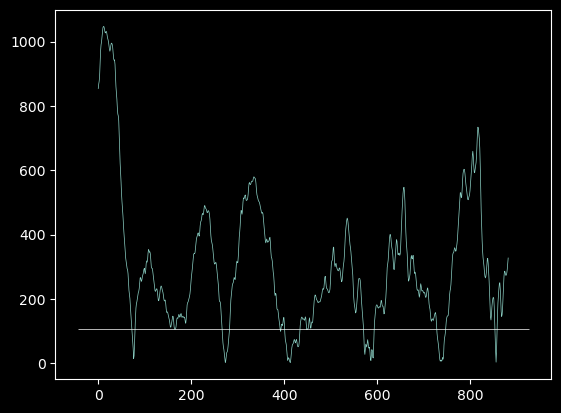

In [ ]:
frame = grouped_frames["å"][0]
print("vol", tools.vol_db(frame))
print("0 ratio", np.sum(abs(frame) < 0.1 * max(frame)) / len(frame))

plt.figure()
plt.plot(abs(frame))
plt.hlines(0.1 * max(abs(frame)), *plt.xlim())
plt.show()